# Проектная работа - **Анализ бизнес-показателей**

### Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.



### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv(r'/datasets/visits_info_short.csv')
orders = pd.read_csv(r'/datasets/orders_info_short.csv')
costs = pd.read_csv(r'/datasets/costs_info_short.csv')

In [3]:
def first_look(df):
    print('---------------------------Первые 5 строк----------------------------')
    display(df.head())
    print(' ')
    print(' ')
    print('--------------Общая информация--------------')
    print(' ')
    print(df.info())
    print(' ')
    print('-------------Пропуски------------- ')
    print(' ')
    count=0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count = +1
    if count == 0:
        print(' ')
        print('Пропусков НЕТ')
    print(' ')
    print('-------------Дубликаты------------ ')
    print(' ')
    if df.duplicated().sum() > 0:
        print(' ')
        print('Дубликатов: ', df.duplicated().sum())
    else:
                print('Дубликатов НЕТ')
    print(' ')  

In [4]:
first_look(visits)

---------------------------Первые 5 строк----------------------------


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
 
-------------Пропуски------------- 
 
 
Пропусков НЕТ
 
-------------Дубликаты------------ 
 
Дубликатов НЕТ
 


In [5]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
visits = visits.rename(columns={'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start','Session End':'session_end'})

In [6]:
first_look(orders)

---------------------------Первые 5 строк----------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
 
-------------Пропуски------------- 
 
 
Пропусков НЕТ
 
-------------Дубликаты------------ 
 
Дубликатов НЕТ
 


In [7]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})

In [8]:
first_look(costs)

---------------------------Первые 5 строк----------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
 
-------------Пропуски------------- 
 
 
Пропусков НЕТ
 
-------------Дубликаты------------ 
 
Дубликатов НЕТ
 


In [9]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
#costs = costs.rename(columns={'Channel':'channel'})
costs.columns = costs.columns.str.lower()

**Выгрузили данные, отредактировали названия столбцов и привели даты к типу datetime. Дубликаты отсутствуют.** 

## Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии

### **Функция для расчёта LTV и ROI**

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### **Функция для визуализации LTV и ROI**

In [11]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(22, 12))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### **Функция для расчёта удержания**

In [12]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### **Функция для визуализации удержания**

In [13]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### **Функция для расчёта конверсии**

In [14]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### **Функция для визуализации конверсии**

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 7))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### **Функция для сглаживания фрейма**

In [16]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

## Проведём исследовательский анализ данных

### **Построим профили пользователей**

In [17]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
profiles = get_profiles(visits, orders, costs)
profiles.head() 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


### **Определим минимальную и максимальную дату привлечения пользователей**

In [19]:
min_analysis_date = profiles['first_ts'].min()
print(min_analysis_date)

2019-05-01 00:00:41


In [20]:
observation_date = profiles['first_ts'].max()
print(observation_date)

2019-10-27 23:59:04


### **Из каких стран приходят посетители. На какую страну приходится больше всего платящих пользователей.**

In [21]:
report = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
report.columns = ['Кол-во пользователей', 'Платящих пользователей', 'Доля платящих']
report.sort_values(by= 'Платящих пользователей', ascending = False).style.format({'Платящих пользователей': '{:.0f}',
                                                                       'Доля платящих': '{:.2%}'})

,Кол-во пользователей,Платящих пользователей,Доля платящих
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


Пользователи приходят из США, Великобритании, Франции и Германии. Абсолютное большинство пользователей из США.

### **Какими устройства у пользователей. С каких устройств чаще всего заходят платящие пользователи.**

In [22]:
device_payer = profiles.groupby('device').agg({'user_id':'nunique','payer':['sum','mean']})
device_payer.columns = ['Кол-во пользователей', 'Платящих пользователей', 'Доля платящих']
device_payer.sort_values(by= 'Платящих пользователей', ascending = False).style.format({'Платящих пользователей': '{:.0f}',
                                                                       'Доля платящих': '{:.2%}'})

,Кол-во пользователей,Платящих пользователей,Доля платящих
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
Mac,30042,1912,6.36%
PC,30455,1537,5.05%


Клиенты пользуются iPhone, Android, PC и Mac. Чаще всего оплачивают владельцы Mac и iPhone.

### **По каким рекламным каналам шло привлечение пользователей. Какие каналы приносят больше всего платящих пользователей.**

In [23]:
channel_payer = profiles.groupby('channel').agg({'user_id':'nunique','payer':['sum','mean']})
channel_payer.columns = ['Кол-во пользователей', 'Платящих пользователей', 'Доля платящих']
channel_payer.sort_values(by= 'Платящих пользователей', ascending = False).style.format({'Платящих пользователей': '{:.0f}',
                                                                       'Доля платящих': '{:.2%}'})

,Кол-во пользователей,Платящих пользователей,Доля платящих
channel,,,
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
organic,56439,1160,2.06%
WahooNetBanner,8553,453,5.30%
AdNonSense,3880,440,11.34%
RocketSuperAds,4448,352,7.91%
LeapBob,8553,262,3.06%
OppleCreativeMedia,8605,233,2.71%
lambdaMediaAds,2149,225,10.47%


ТОП-3 среди каналов по количеству платящих пользователей - **FaceBoom, TipTop и organic** соответственно. Но в процентном соотношении привлечённые/платящие ТОП-3 выглядит так: **FaceBoom, AdNonSense, lambdaMediaAds**.

## Маркетинг

### **Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик по времени**

In [24]:
profiles['acquisition_cost'].sum().round(2)

105497.3

In [25]:
channel_cost = profiles.groupby('channel').agg({'acquisition_cost':'sum'})
channel_cost.sort_values(by='acquisition_cost',ascending=False)

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [26]:
cost_time = pd.pivot_table(costs, index='dt', columns='channel', values='costs', aggfunc='sum' )
cost_time

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
2019-05-01,40.95,113.3,2.52,6.24,4.25,21.060,80.0,10.8,8.10,17.6
2019-05-02,34.65,78.1,2.94,5.04,4.25,16.965,55.0,7.2,9.90,16.8
2019-05-03,47.25,85.8,2.73,6.96,5.75,16.380,64.0,8.4,9.00,16.8
2019-05-04,51.45,136.4,3.99,9.36,4.25,17.550,70.0,10.8,15.60,17.6
2019-05-05,36.75,122.1,4.62,11.04,5.50,27.495,78.0,12.0,9.60,12.8
...,...,...,...,...,...,...,...,...,...,...
2019-10-23,15.75,178.2,10.71,5.28,13.25,5.525,322.0,31.8,6.48,4.0
2019-10-24,21.00,222.2,12.81,5.04,12.50,5.850,402.5,42.0,7.29,6.4
2019-10-25,26.25,255.2,14.70,6.24,16.50,7.150,483.0,37.2,7.56,8.8


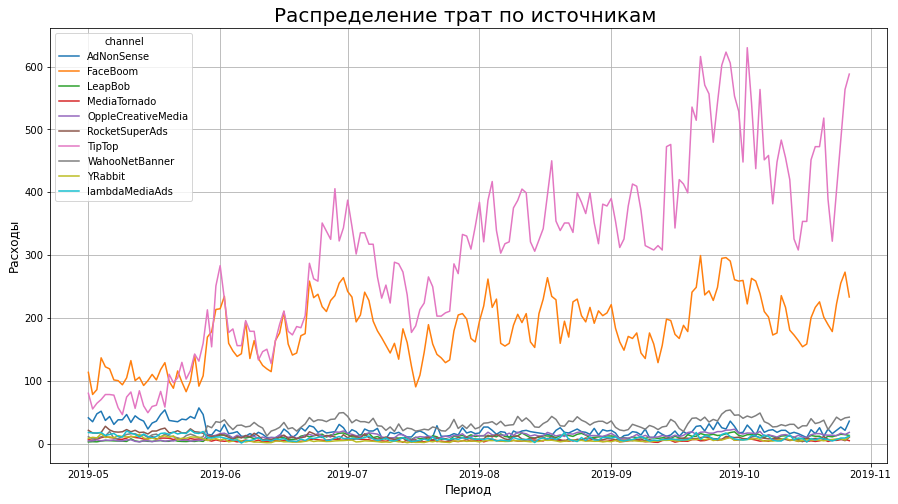

In [27]:
cost_time.plot(grid=True, figsize=(15,8))
plt.title("Распределение трат по источникам ",fontsize=20)
plt.xlabel("Период",fontsize=12)
plt.ylabel("Расходы",fontsize=12)
plt.show()

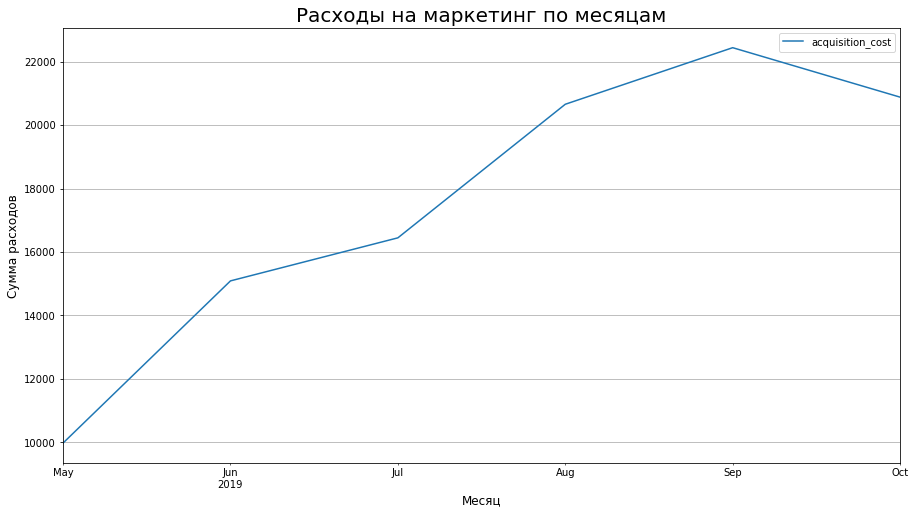

In [28]:
metrics_time = (pd.pivot_table(profiles, index='month',values='acquisition_cost', aggfunc='sum')
                .plot(grid=True,figsize=(15,8))
)
plt.title("Расходы на маркетинг по месяцам",fontsize=20)
plt.xlabel("Месяц",fontsize=12)
plt.ylabel("Сумма расходов",fontsize=12)
plt.show()

Общую сумма расходов на маркетинг с 01.05.2019 по 27.10.2019 составляет - 105497,3. Лидеры по затратам TipTop и FaceBoom. С мая по сентябрь сумма расходов увеличивалась. В октябре заметен небольшой спад, но у нас данные только до 27 октября.

### **Узнаем, сколько стоило в среднем привлечение одного пользователя из каждого источника.**Расчитаем средний CAC на одного пользователя для всего проекта и для каждого источника.**

In [29]:
cac_channel = pd.pivot_table(profiles, index='channel',values='acquisition_cost',aggfunc='mean').round(2)
cac_channel.sort_values(by='acquisition_cost',ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
MediaTornado,0.22
YRabbit,0.22


In [30]:
mean_cac = profiles.query('channel != "organic"')
print('Средний CAC проекту:',mean_cac['acquisition_cost'].mean())

Средний CAC проекту: 1.127481323942928


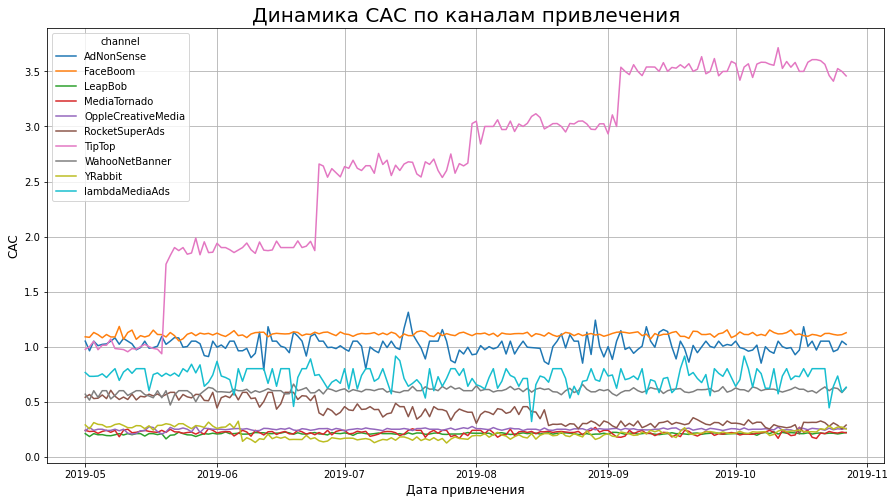

In [31]:
mean_cac.pivot_table(index='dt',columns='channel',values='acquisition_cost',aggfunc='mean').plot(grid=True,figsize=(15,8))
plt.ylabel('CAC',fontsize=12)
plt.xlabel('Дата привлечения',fontsize=12)
plt.title('Динамика САС по каналам привлечения',fontsize=20)
plt.show()

Средняя стоимость привлечения одного пользователя по проекту - 1.13. По каналам явно выделяется **TipTop** со средним САС 2,8 и в динамике приблизительно от 1 до 3,7. Остальные каналы в динамике более стабильны.

## Оценим окупаемость рекламы для привлечения пользователей


###  Проанализируем общую окупаемость рекламы

In [32]:
# обозначим момент и горизонт анализа
observation_date = datetime(2019,11,1).date()
horizon_days = 14

# исключим органических пользователей, т.к. они помешают расчёту окупаемости рекламы
profiles = profiles.query('channel != "organic"')

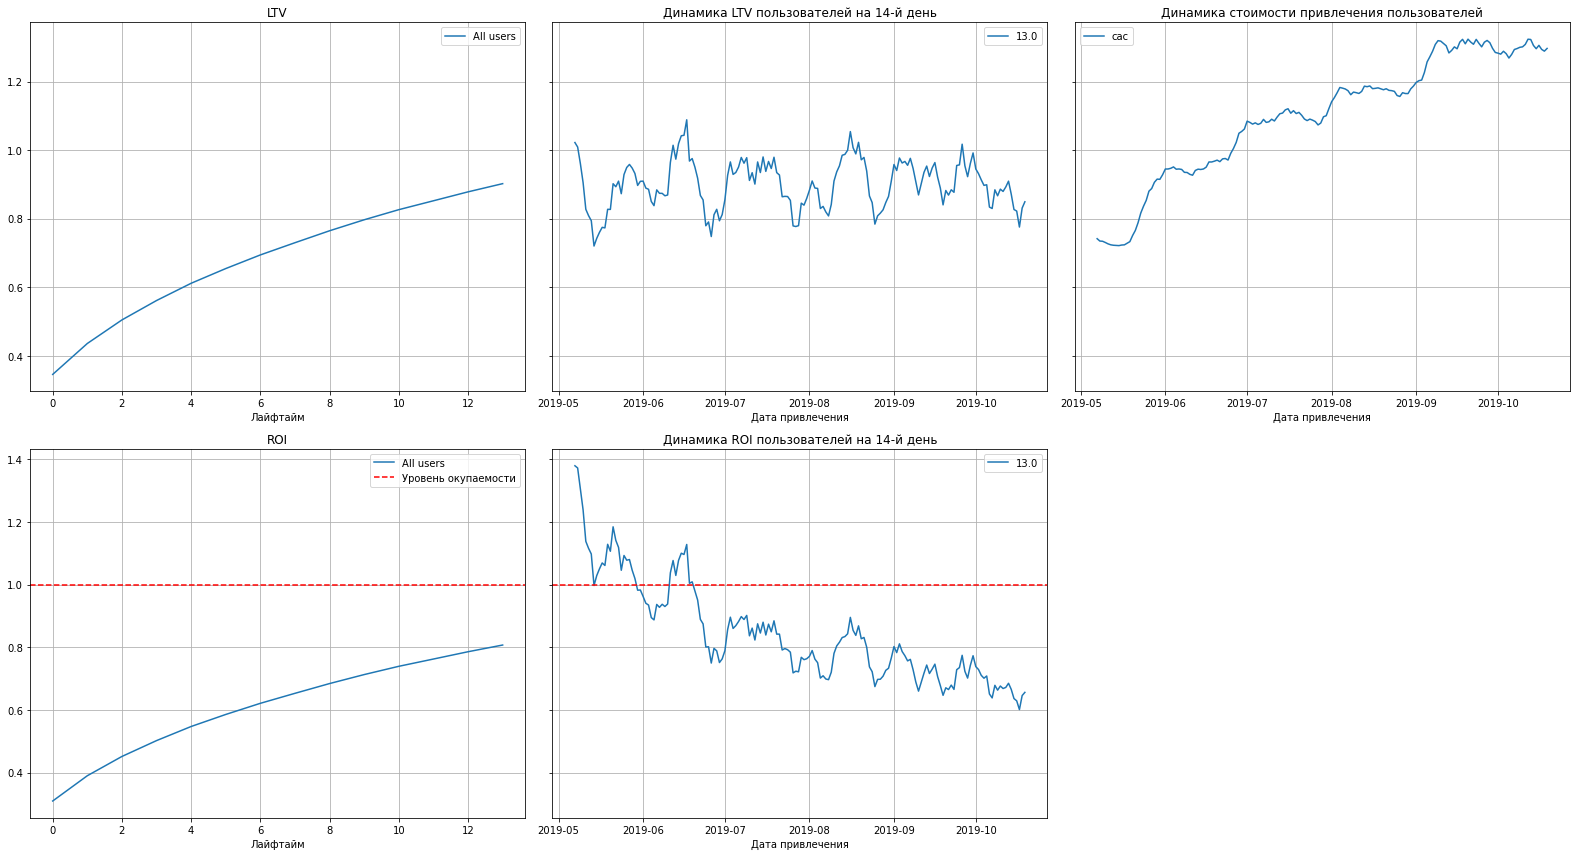

In [33]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- График LTV растёт(всё в норме);
- График динамики LTV пользователей на 14 день - нестабильный. Колебания от ~ 0.7 до 1.1;
- Динамика стоимости привлечения увеличивается, что говорит о повышении затрат на рекламу;
- График ROI не пересекает уровень окупаемости, что говорит о не окупаемости маркетинговых затрат;
- Динамика ROI падает соответственно росту затрат на рекламу.

###  Проанализируем окупаемость рекламы с разбивкой по устройствам

In [34]:
dimensions = ['device']

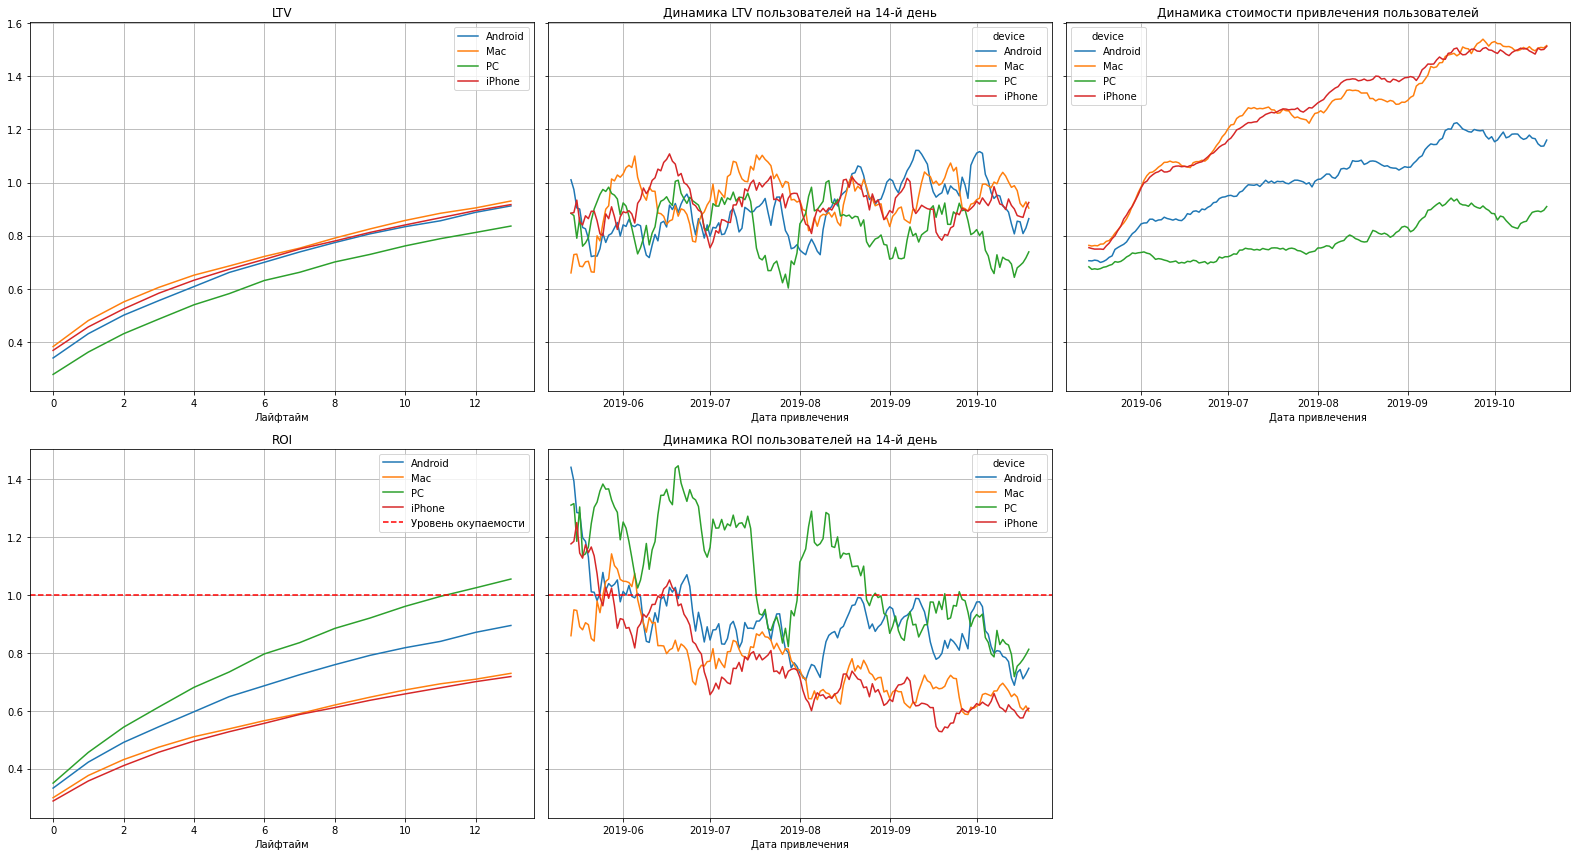

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- Графики LTV у всех девайсов растут;
- Динамика LTV у всех устройств нестабильна;
- Стоимость привлечения пользователей у Mac и iPhone растёт значительно быстрее, чем у Android и PC, что говорит о больших вложениях в рекламу;
- Лишь у PC вложения в маркетинг окупаются;
- Динамика ROI постепенно снижается у всех устройств, у PC  с большими колебаниями во второй половине июля. Mac и iPhone удаётся стабилизировать падение динамики ROI с июля(на фоне роста затрат на рекламу, можно отметить её бОльшую эффективность). 

###  Проанализируем окупаемость рекламы с разбивкой по странам

In [36]:
dimensions = ['region']

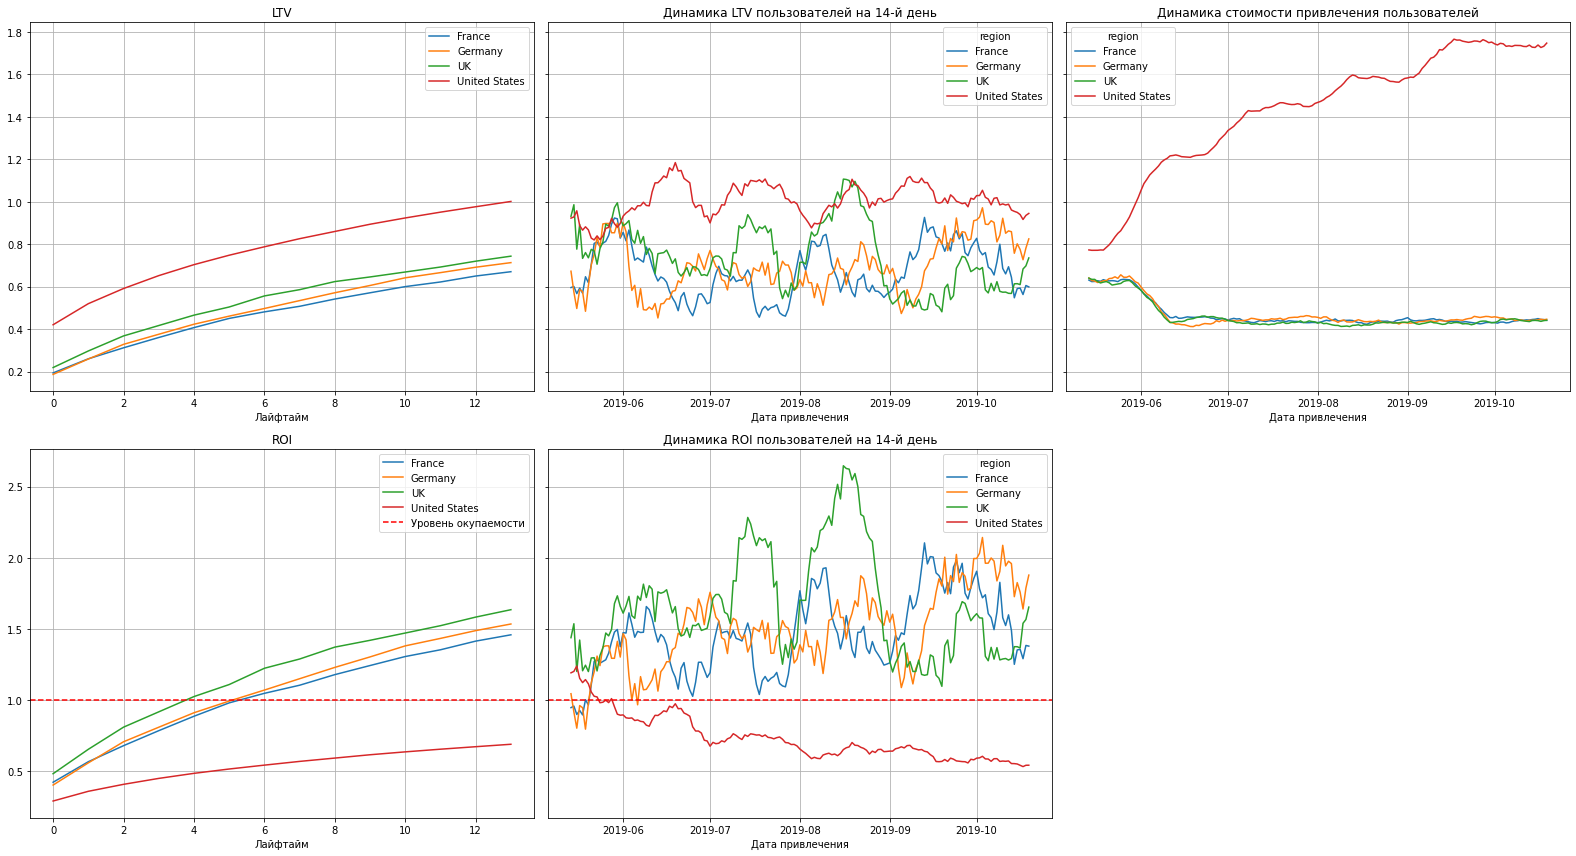

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

- LTV в США значительно выше чем во Франции, Германии и Великобритании;
- Динамика LTV имеет сильные колебания в Великобритании(июль,август) и в Германии,Франции(май-июнь и сентябрь-октябрь. В США динамика LTV более стабильна;
- В США расходы на маркетинг стремительно растут с середины мая. В Германии, Франции и Великобритании затраты на рекламу резко снижаются в конце мая и стабилизируются на одном уровне в первой половине июня;
- Кривая ROI в США значительно ниже уровня окупаемости. В остальных странах реклама окупается;
- Динамика ROI пользователей из США падает. В остальных странах растёт, но с большими колебаниями(особенно июль-август в Великобритании.


### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

In [38]:
dimensions = ['channel']

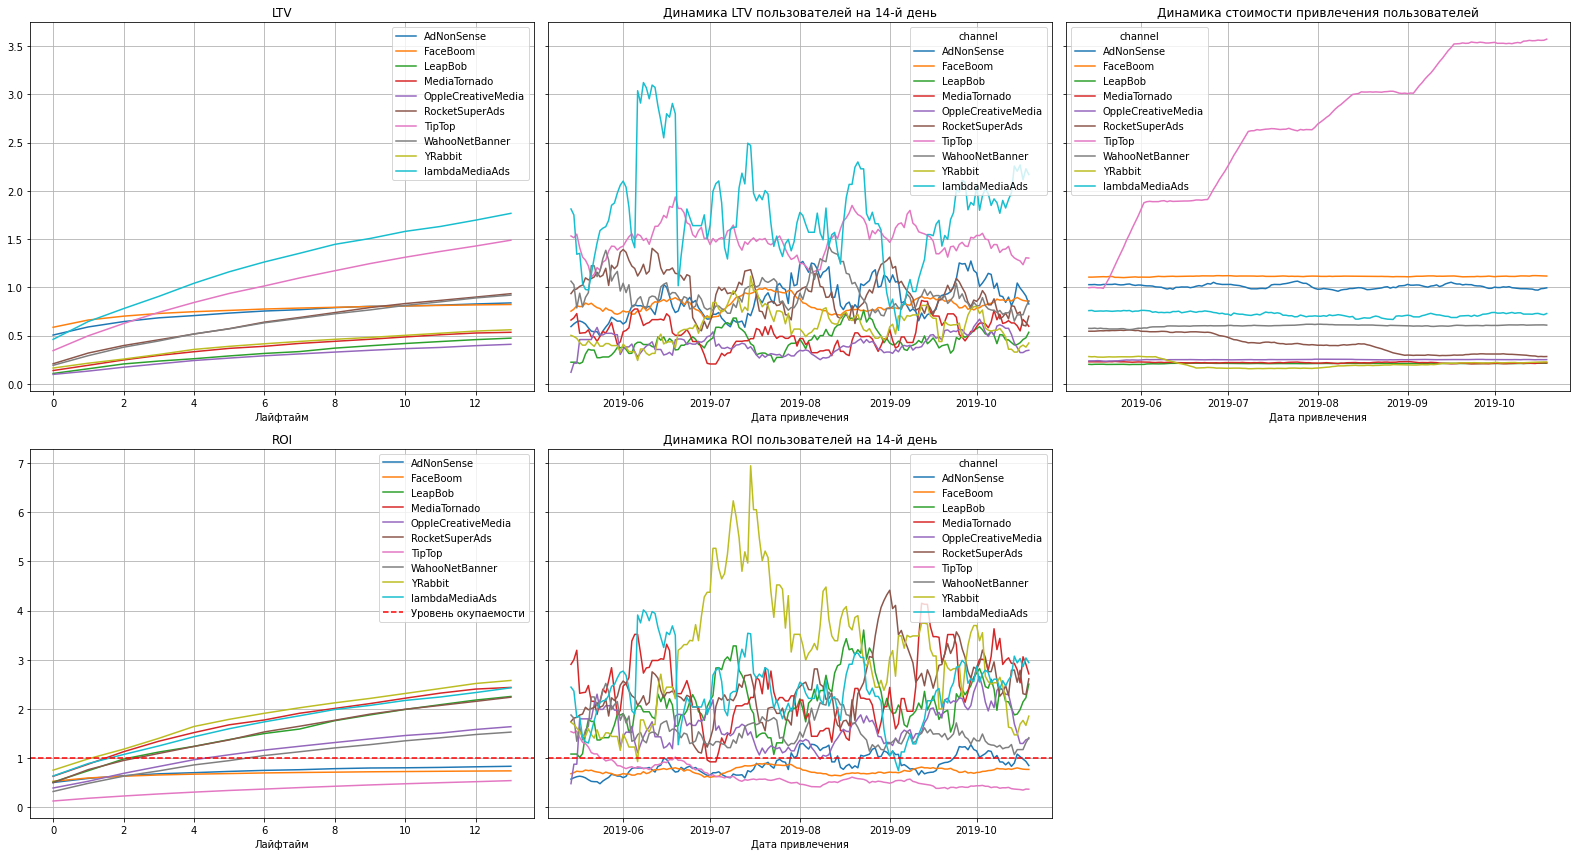

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

- График LTV особенно быстро растёт у LambdaMediaAds и TipTop;
- Динамика LTV пользователей выше у LambdaMediaAds и TipTop, но также имеет более сильные колебания(особенно у LambdaMediaAds;
- Динамика CAC ступенчато растёт у TipTop. У остальных стабильно одинаковая;
- TipTop, FaceBoom и AdNonSense не окупаются. Остальные кривые пересекают уровень окупаемости;
- Динамика ROI сильно выделяется у YRabbit в июне-июле.

### Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам и рекламным     каналам

#### Конверсия с разбивкой по устройствам

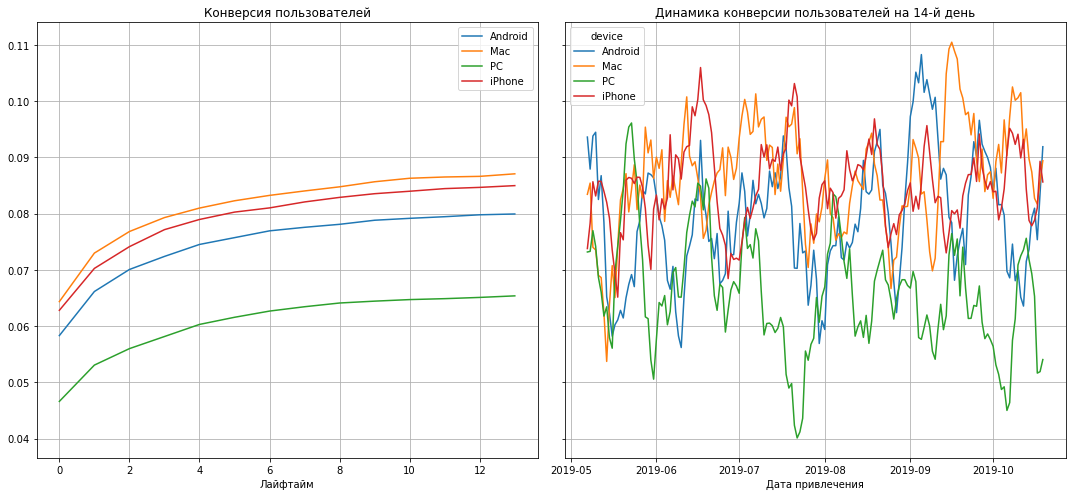

In [40]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Конверсия пользователей PC значительно ниже пользователей осталных устройств. Также в динамике конверсия PC имеет серьёзные провалы.

#### Удержание с разбивкой по устройствам

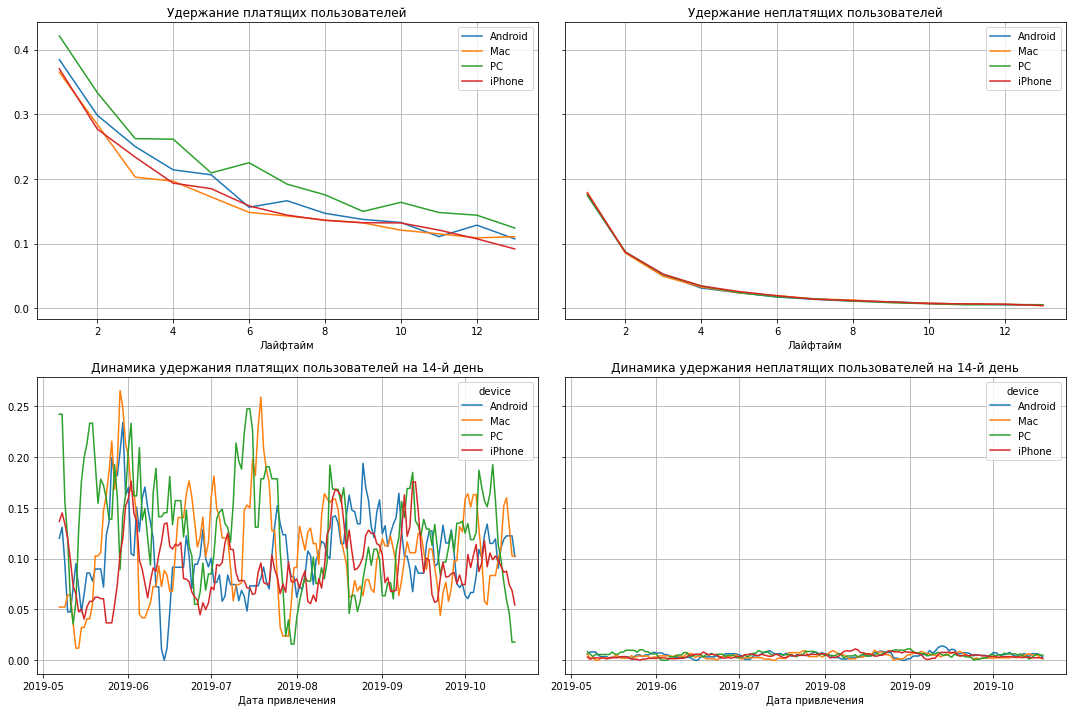

In [41]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Динамика удержания платящих пользователей на 14-й день имеет сильные колебания с мая по август. С середины августа стабилизируется.

#### Конверсия  с разбивкой по странам

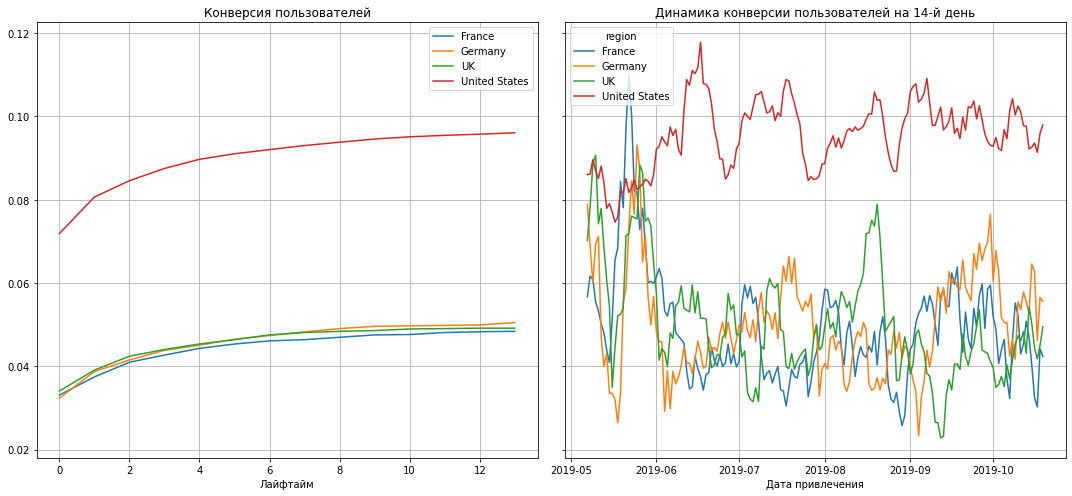

In [42]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Конверсия в США значительно выше чем в Германии, Франции и Великобритании. То же наблюдается в динамике с июня.

#### Удержание с разбивкой по странам

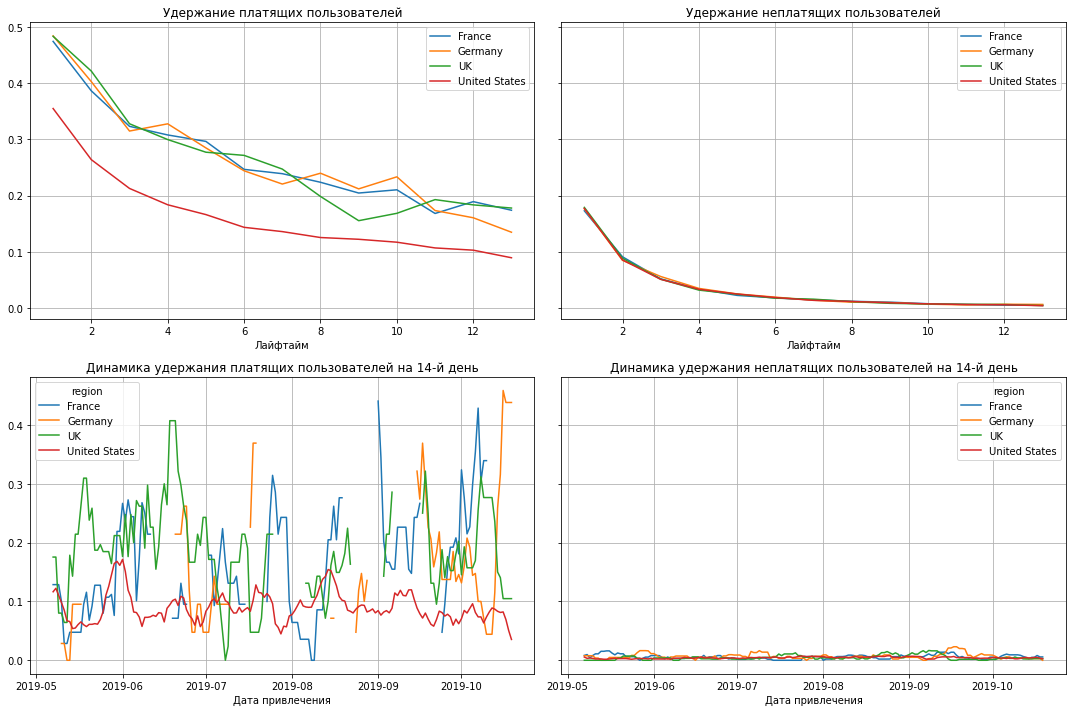

In [43]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание платящих пользователей в США значительно ниже других стран. В динамике удержания на 14-й день, США также значительно ниже, но у других стран на кривых много разрывов - это говорит о том, что для этих дат привлечения на 14-ый день никто не остался, либо данные отсутствуют.

#### Конверсия  с разбивкой по рекламным каналам

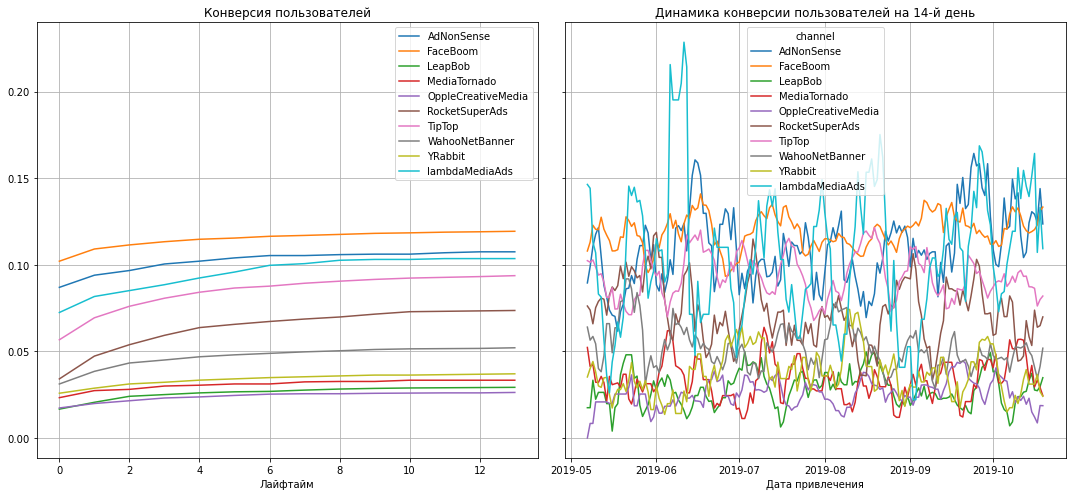

In [44]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Лидер из рекламных каналов по конверсии пользователей - FaceBoom. В динамике конверсии, переодическими скачками, выделяется LambdaMediaAds. 

####  Удержание с разбивкой по рекламным каналам

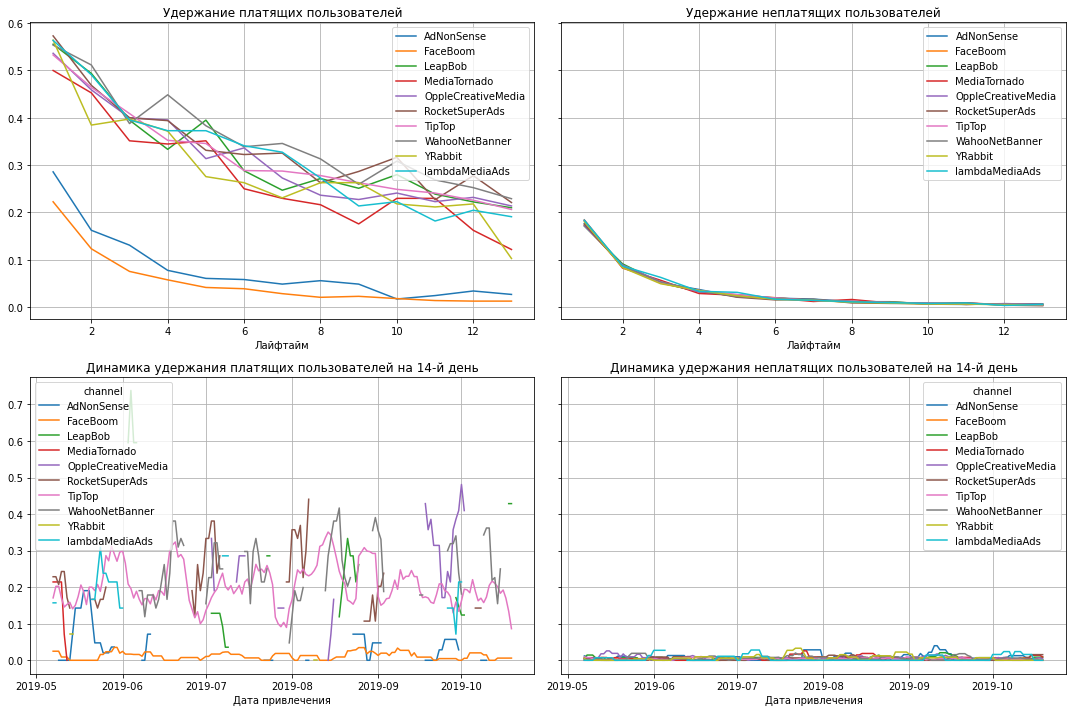

In [45]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание платящих пользователей AdNonSense и FaceBoom значительно ниже остальных рекламных каналов. В динамике удержания платящих пользователей очень много разрывов, кроме FaceBoom.

#### Выводы по окупаемости рекламы

- Реклама не окупается, ROI чуть больше 80%;
- Mac и iPhone сильно снижают окупаемость рекламы;
- США единственная из стран, где реклама не окупается;
- Вложения в TipTop, FaceBoom и AdNonSense не окупаются.

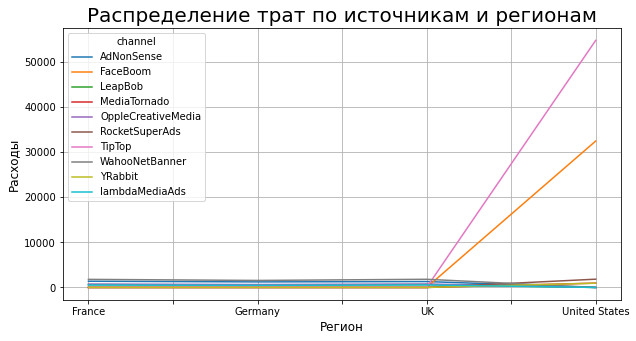

In [46]:
problems = profiles.pivot_table(index='region',columns='channel',values='acquisition_cost',aggfunc='sum').fillna(0).round(0)
problems.plot(grid=True,figsize=(10,5))
plt.title("Распределение трат по источникам и регионам",fontsize=20)
plt.xlabel("Регион",fontsize=12)
plt.ylabel("Расходы",fontsize=12)
plt.show()

In [47]:
problems

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
region,,,,,,,,,,
France,1376.0,0.0,628.0,0.0,747.0,0.0,0.0,1789.0,0.0,535.0
Germany,1229.0,0.0,530.0,0.0,641.0,0.0,0.0,1553.0,0.0,471.0
UK,1306.0,0.0,640.0,0.0,763.0,0.0,0.0,1809.0,0.0,551.0
United States,0.0,32446.0,0.0,954.0,0.0,1833.0,54751.0,0.0,944.0,0.0


- Возможная причина проблемы окупаемости рекламы кроется в том, что США, являясь крупнейшим пользователем Procrastinate Pro+, вкладывает средства в неокупаемые(большая стоимость привлечения) рекламные каналы TipTop и FaceBoom. Также возможны технические проблемы с Mac и iPhone;
- В остальных странах ситуация с окупаемостью лучше, и как видно из таблицы они равномерно распределяют средства по рекламным каналам;
- Возможным решением проблемы будет перераспределение маркетингового бюджета(нужно обратить внимание на "YRabbit") и привлечение новых каналов.

## Выводы

**Основные причины неэффективности привлечения пользователей:**
- Неокупаемость вложенного рекламного бюджета - 83%, в TipTop и FaceBoom;
- Резкий спад окупаемости Mac и iPhone с середины июня;
- Резкий рост стоимости привлечения у TipTop с середины мая;
- Низкое удержание платящих пользователей в США (к концу 2-ой недели < 10%);
- Очень низкое удержание платящих пользователей у FaceBoom (к концу 2-ой недели около 0).

**Рекомендации отделу маркетинга для повышения эффективности:**
- Перераспределение маркетингового бюджета внутри США(хорошо себя показал YRabbit, а также RocketSuperAds и MediaTornado);
- Поиск новых рекламных каналов в США;
- Перераспределение маркетингового бюджета из США на европейский рынок(Германия, Франция, Великобритания);
- Поиск возможной технической проблемы у владельцов Mac и iPhone.